In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your dataset
infected_folder = '/content/drive/My Drive/cell_images_subset/Parasitized/'
uninfected_folder = '/content/drive/My Drive/cell_images_subset/Uninfected/'


Mounted at /content/drive


In [3]:
# Function to load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize to a consistent size
            images.append(img)
            labels.append(label)
    return images, labels

In [4]:
# Load infected and uninfected images
infected_images, infected_labels = load_images_from_folder(infected_folder, 1)  # 1 for infected
uninfected_images, uninfected_labels = load_images_from_folder(uninfected_folder, 0)  # 0 for uninfected


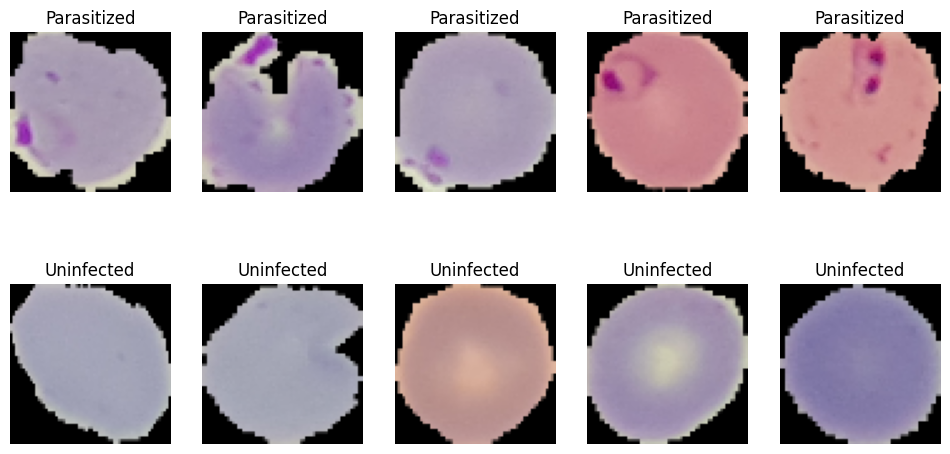

In [5]:
# Display sample images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(infected_images[i], cv2.COLOR_BGR2RGB))
    plt.title("Parasitized")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(cv2.cvtColor(uninfected_images[i], cv2.COLOR_BGR2RGB))
    plt.title("Uninfected")
    plt.axis('off')
plt.show()

In [6]:
# Combine the data
images = np.array([img.flatten() for img in infected_images + uninfected_images])
labels = np.array(infected_labels + uninfected_labels)

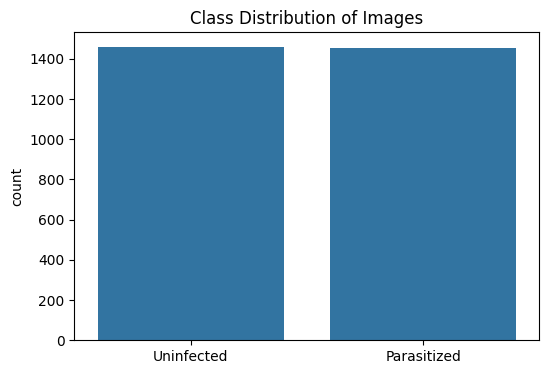

In [7]:
# Display class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title('Class Distribution of Images')
plt.xticks([0, 1], ['Uninfected', 'Parasitized'])
plt.show()

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA to visualize data in 2D space
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

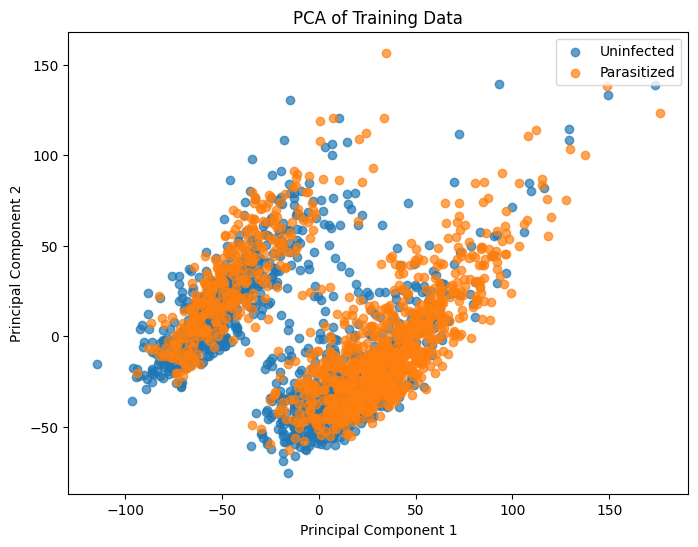

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[y_train == 0, 0], X_train_pca[y_train == 0, 1], alpha=0.7, label='Uninfected')
plt.scatter(X_train_pca[y_train == 1, 0], X_train_pca[y_train == 1, 1], alpha=0.7, label='Parasitized')
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [10]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=3)  # You can tune the 'n_neighbors' parameter

# Train the KNN model
knn.fit(X_train, y_train)

# Predict on the test data
y_pred = knn.predict(X_test)

In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.60
Confusion Matrix:
[[260  32]
 [203  88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.89      0.69       292
           1       0.73      0.30      0.43       291

    accuracy                           0.60       583
   macro avg       0.65      0.60      0.56       583
weighted avg       0.65      0.60      0.56       583



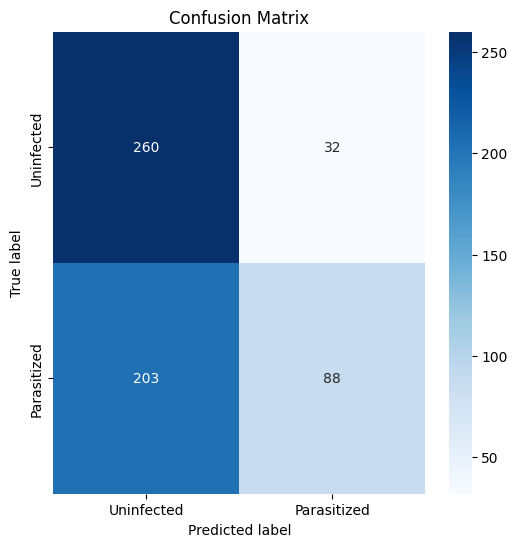

In [12]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

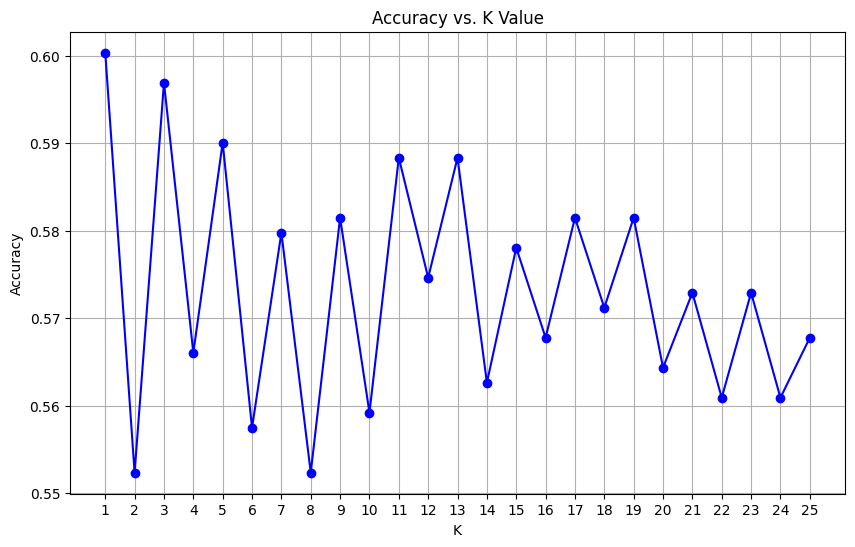

In [13]:
# Find the best k value
k_range = range(1, 26)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred_k))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.grid()
plt.show()

In [32]:
print(f"The best accuracy was {max(scores):.2f} with k = {scores.index(max(scores)) + 1}")

The best accuracy was 0.60 with k = 1


In [15]:
# Import necessary libraries for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
# Reshape images back to original 2D format for CNN
images_reshaped = np.array([cv2.resize(img, (64, 64)) for img in infected_images + uninfected_images])
labels = np.array(infected_labels + uninfected_labels)

In [17]:
# Normalize the images to the range [0, 1]
images_reshaped = images_reshaped / 255.0

# Convert labels to categorical (one-hot encoding)
labels_categorical = to_categorical(labels, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_reshaped, labels_categorical, test_size=0.2, random_state=42, stratify=labels)


In [18]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the CNN model architecture
cnn_model.summary()

# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the CNN model
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,354 (2.61 MB)

 Trainable params: 683,906 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.9661 - loss: 0.0847 - val_accuracy: 0.9297 - val_loss: 0.4534
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9864 - loss: 0.0475 - val_accuracy: 0.9314 - val_loss: 0.4891
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.9830 - loss: 0.0531 - val_accuracy: 0.9468 - val_loss: 0.5144


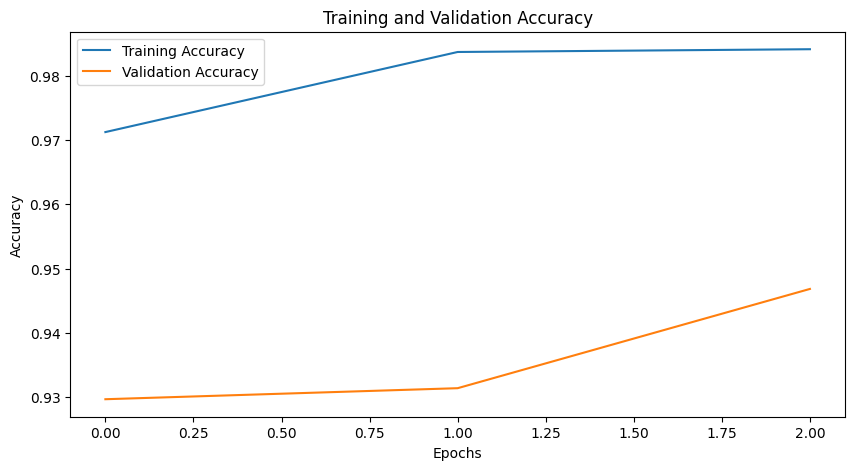

In [24]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

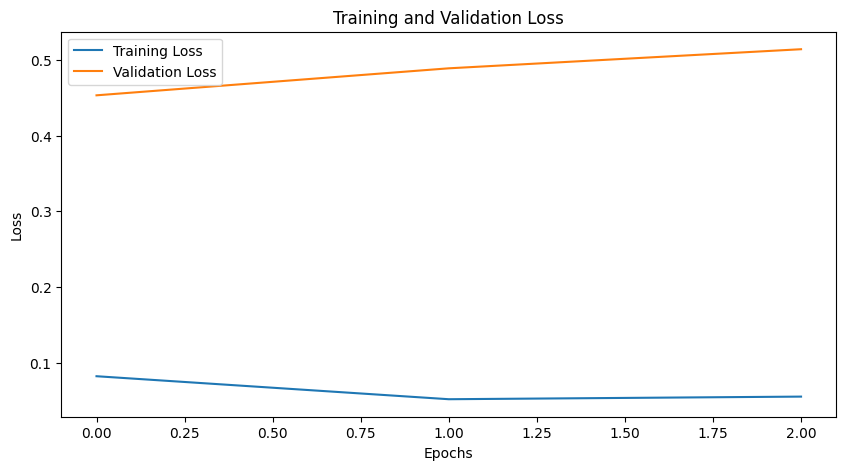

In [25]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9199 - loss: 0.3793
Test Accuracy: 0.93


In [27]:
# Make predictions on the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Confusion Matrix:
[[286   6]
 [ 35 256]]


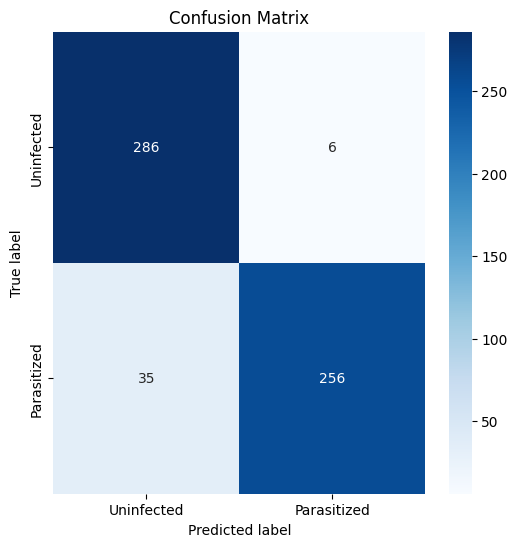

In [28]:

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
# Classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=['Uninfected', 'Parasitized'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.89      0.98      0.93       292
 Parasitized       0.98      0.88      0.93       291

    accuracy                           0.93       583
   macro avg       0.93      0.93      0.93       583
weighted avg       0.93      0.93      0.93       583

